<a href="https://colab.research.google.com/github/tdorai/helloworld/blob/readme-edits/Copy_of_Concrete_Compressive_Strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Prediciting Compressive Strength in Concrete Mixes <center/>

## <center> An exploration with ensemble, gradient boosting, and deep learning methods <center/>
    
## <center> By Joemichael Alvarez <center/>

***Data Set:*** `Concrete_Data.xls`:
[here](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

***Data Set Information:***

- **Number of instances 1030**

- **Number of Attributes 9**

- **Attribute breakdown 8 quantitative input variables, and 1 quantitative output variable**

- **Missing Attribute Values None**

***Attribute Information:***

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

- **Cement (component 1)**-- quantitative -- kg in a m3 mixture -- Input Variable
- **Blast Furnace Slag (component 2)** -- quantitative -- kg in a m3 mixture -- Input Variable
- **Fly Ash (component 3)** -- quantitative -- kg in a m3 mixture -- Input Variable
- **Water (component 4)** -- quantitative -- kg in a m3 mixture -- Input Variable
- **Superplasticizer (component 5)** -- quantitative -- kg in a m3 mixture -- Input Variable
- **Coarse Aggregate (component 6)**-- quantitative -- kg in a m3 mixture -- Input Variable
- **Fine Aggregate (component 7)**-- quantitative -- kg in a m3 mixture -- Input Variable
- **Age** -- quantitative -- Day (1~365)-- Input Variable
- **Concrete compressive strength**-- quantitative -- MPa -- Output Variable

# Defining Our Problem

Before approaching our problem using a machine learning algorithms, it's important that we explore our problem with a fine tooth comb. This includes, ensuring no missing values, exploring outliers, normalization, and checking for duplicate values. Once we address these potential issues then we can begin addressing our core issue.

__We seek to predict concrete compressive strength using a list of ingredients as well as the amount of time the concrete is allowed to set before testing.__

# Domain Knowledge
I have personally conducted compression strength testing on concrete blocks while studying civil engineering. While this does not make me an expert it does give me better perspective on the metadata,

# Non-Linearity

"Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients."

# Data Preprocessing

## Instillations

In [ ]:
!pip install xgboost catboost lightgbm scikit-optimize tensorflow tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libraries

In [ ]:
#required libraries
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop,  Nadam
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow_addons.metrics import RSquare

#quality of life
tf.random.set_seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load the Dataset

In [ ]:
#load the xls:
ccs= pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls')

### Initial Inspection

In [ ]:
#display first few records vertically and rounded
ccs.head(10).round(2).T

,0,1,2,3,4,5,6,7,8,9
Cement (component 1)(kg in a m^3 mixture),540.00,540.00,332.50,332.50,198.6,266.00,380.0,380.00,266.00,475.00
Blast Furnace Slag (component 2)(kg in a m^3 mixture),0.00,0.00,142.50,142.50,132.4,114.00,95.0,95.00,114.00,0.00
Fly Ash (component 3)(kg in a m^3 mixture),0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
Water (component 4)(kg in a m^3 mixture),162.00,162.00,228.00,228.00,192.0,228.00,228.0,228.00,228.00,228.00
Superplasticizer (component 5)(kg in a m^3 mixture),2.50,2.50,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
Coarse Aggregate (component 6)(kg in a m^3 mixture),1040.00,1055.00,932.00,932.00,978.4,932.00,932.0,932.00,932.00,932.00
Fine Aggregate (component 7)(kg in a m^3 mixture),676.00,676.00,594.00,594.00,825.5,670.00,594.0,594.00,670.00,594.00
Age (day),28.00,28.00,270.00,365.00,360.0,90.00,365.0,28.00,28.00,28.00
"Concrete compressive strength(MPa, megapascals)",79.99,61.89,40.27,41.05,44.3,47.03,43.7,36.45,45.85,39.29


In [ ]:
#basic statistics for our columns
ccs.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Cement (component 1)(kg in a m^3 mixture),1030.0,281.17,104.51,102.00,192.38,272.90,350.00,540.0
Blast Furnace Slag (component 2)(kg in a m^3 mixture),1030.0,73.90,86.28,0.00,0.00,22.00,142.95,359.4
Fly Ash (component 3)(kg in a m^3 mixture),1030.0,54.19,64.00,0.00,0.00,0.00,118.27,200.1
Water (component 4)(kg in a m^3 mixture),1030.0,181.57,21.36,121.75,164.90,185.00,192.00,247.0
Superplasticizer (component 5)(kg in a m^3 mixture),1030.0,6.20,5.97,0.00,0.00,6.35,10.16,32.2
Coarse Aggregate (component 6)(kg in a m^3 mixture),1030.0,972.92,77.75,801.00,932.00,968.00,1029.40,1145.0
Fine Aggregate (component 7)(kg in a m^3 mixture),1030.0,773.58,80.18,594.00,730.95,779.51,824.00,992.6
Age (day),1030.0,45.66,63.17,1.00,7.00,28.00,56.00,365.0
"Concrete compressive strength(MPa, megapascals)",1030.0,35.82,16.71,2.33,23.71,34.44,46.14,82.6


In [ ]:
#this is how i like to display the shape of my df
ccs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

The necessary components for concrete are cement, water, coarse aggregate, and fine aggregate. This alongside with time to dry are the minimum to create concrete. As expected because of this the minimum for blast furnace slag, fly ash, and superplasticizer are 0. There seems to be some outliers based off of the range between 75% (3rd quartile) and the max of each column, but we'll make sure of that during univariate analysis.

Let's move on to renaming our columns. While its nice to know the units our columns our measured in, I'd like to keep that in the metadata instead of in the column name. We'll also be removing the spaces in the column names and sticking to pascal case for our column names.

## Data Cleaning

In [ ]:
#renaming columns with for loop
new_names = []
column_name = ''

for i in ccs.columns: #list columns
  count = 0
  for y in i: #list letters in columns
    if y == '(':
      break
    else:
      count +=1
    column_name = i[:count]
  new_names.append(column_name.replace(" ","")) #remove whitespace

ccs.columns = new_names

ccs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cement                       1030 non-null   float64
 1   BlastFurnaceSlag             1030 non-null   float64
 2   FlyAsh                       1030 non-null   float64
 3   Water                        1030 non-null   float64
 4   Superplasticizer             1030 non-null   float64
 5   CoarseAggregate              1030 non-null   float64
 6   FineAggregate                1030 non-null   float64
 7   Age                          1030 non-null   int64  
 8   Concretecompressivestrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Looks much better. Now lets just manually adjust our dependant variable's name.

In [ ]:
#manually renaming
ccs_final = ccs.rename(columns={'Concretecompressivestrength': 'CompressiveStrength'})

ccs_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   BlastFurnaceSlag     1030 non-null   float64
 2   FlyAsh               1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   CoarseAggregate      1030 non-null   float64
 6   FineAggregate        1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   CompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Looks much better. Lets inspect our dataset for data veracity issues (missing values/data type issues/duplicates).

In [ ]:
#checking for nulls
missing_data = ccs_final.isnull()

#prints no missing values for all columns unless nulls exist
for column in missing_data.columns.values.tolist():
  if missing_data[column].sum() != 0:
    print(column)
    print (missing_data[column].sum())
    print("")
  else:
    print(column,"has no missing values\n")

Cement has no missing values

BlastFurnaceSlag has no missing values

FlyAsh has no missing values

Water has no missing values

Superplasticizer has no missing values

CoarseAggregate has no missing values

FineAggregate has no missing values

Age has no missing values

CompressiveStrength has no missing values



In [ ]:
#checks for non-numbers in our values
for i in ccs_final.columns:
  try:
      ccs_final[i].astype(int)
      print('All values in', i, 'does not contain string\n')
  except ValueError:
      print('There are non-integer values in', i)
      print("")

All values in Cement does not contain string

All values in BlastFurnaceSlag does not contain string

All values in FlyAsh does not contain string

All values in Water does not contain string

All values in Superplasticizer does not contain string

All values in CoarseAggregate does not contain string

All values in FineAggregate does not contain string

All values in Age does not contain string

All values in CompressiveStrength does not contain string



At this point the question gets asked __if__ we should drop duplicates. In most circumstances this decision should be made with domain knowledge or consulting someone more familiar with the data sourcing process.

Based off my previous experience with creating concrete blocks for compressive force testing, duplicates are typically made for redundancy since concrete blocks may break or become faulty duing the molding and drying process. Because of this I'll be dropping these columns since they provide no new data and may only bias our model.

In [ ]:
#removing duplicate values
ccs_final = ccs_final.drop_duplicates(keep='first')
ccs_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1005 non-null   float64
 1   BlastFurnaceSlag     1005 non-null   float64
 2   FlyAsh               1005 non-null   float64
 3   Water                1005 non-null   float64
 4   Superplasticizer     1005 non-null   float64
 5   CoarseAggregate      1005 non-null   float64
 6   FineAggregate        1005 non-null   float64
 7   Age                  1005 non-null   int64  
 8   CompressiveStrength  1005 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 78.5 KB


# <center>EDA

## Univariate Analysis

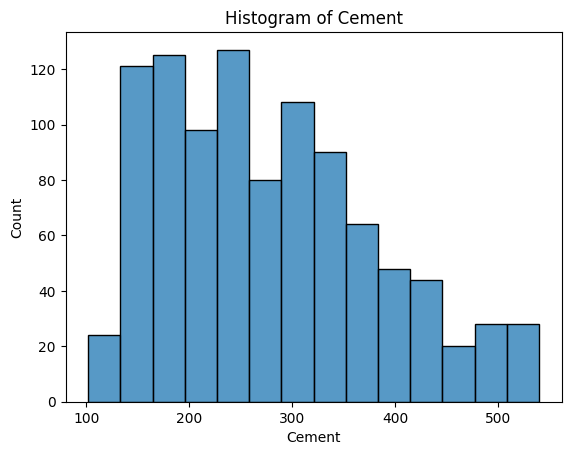

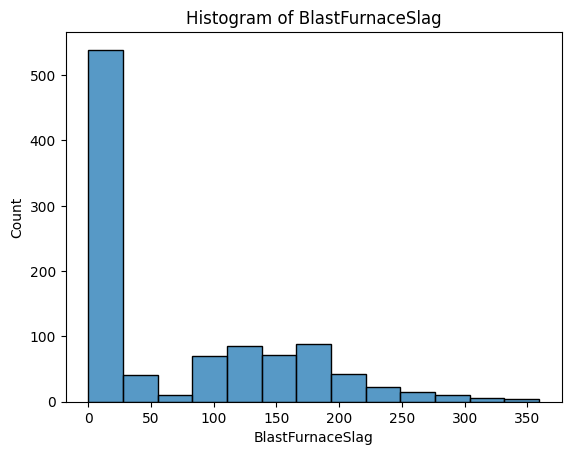

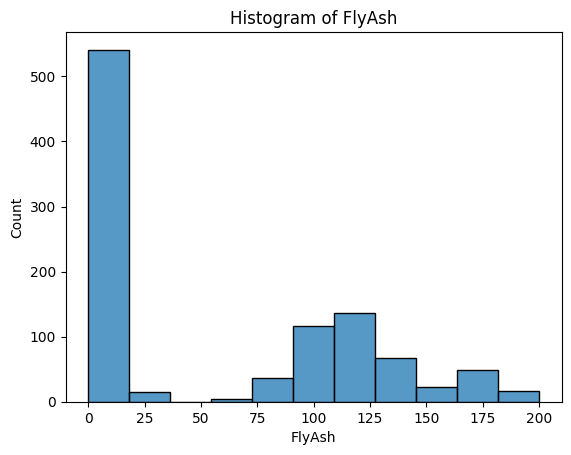

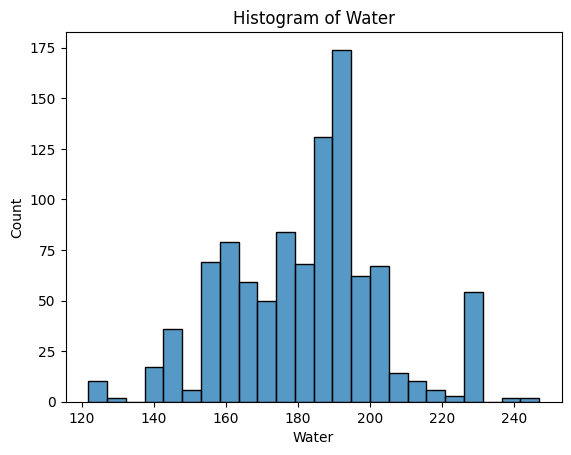

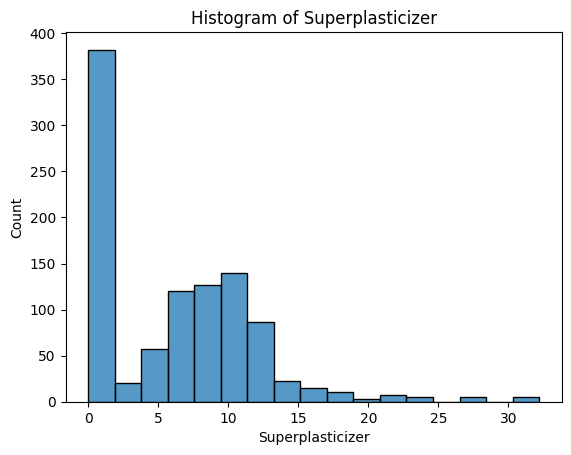

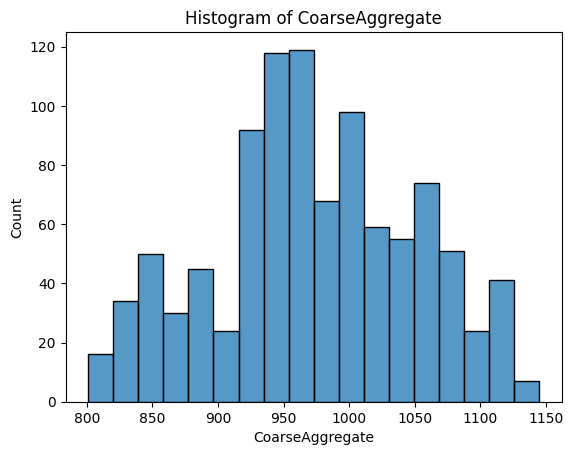

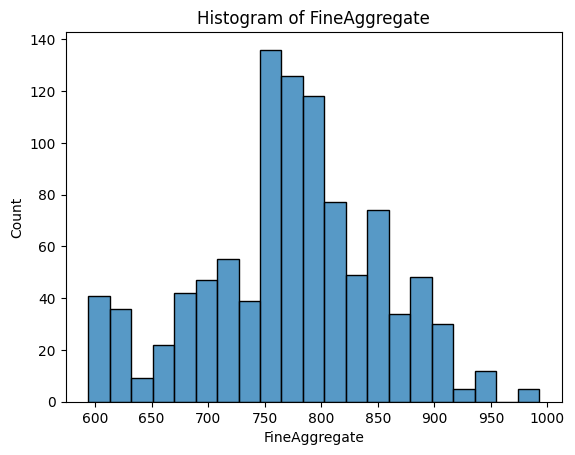

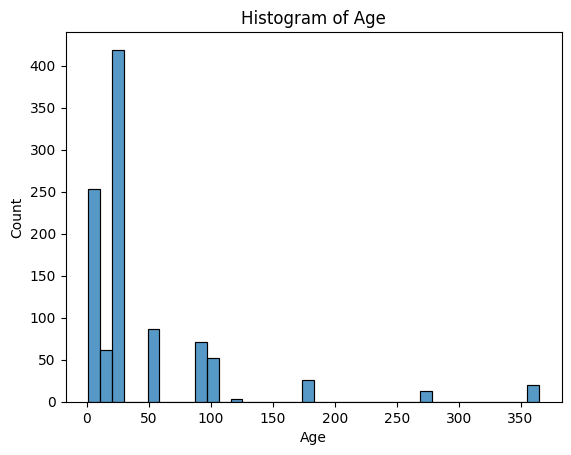

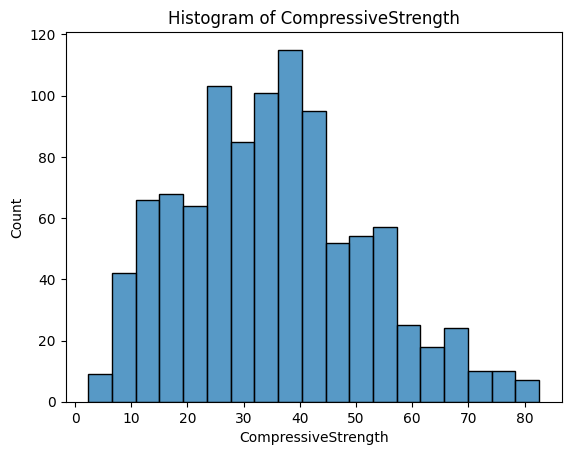

In [ ]:
#histogram univariate
for col in ccs_final.columns:
      plt.figure()
      sns.histplot(data=ccs_final, x=col, multiple="dodge")
      plt.title(f"Histogram of {col}")
      plt.show()

Lots of front loading in our non essential columns (blast furnace slag, fly ash, superplasticizer) as well as age. The rest of our columns seem to have some fairly even (gaussian) distributions with a bit of a skew here and there.

In [ ]:
ccs_final['Age'].value_counts()

28     419
3      129
7      122
56      86
14      62
90      54
100     52
180     26
91      17
365     14
270     13
360      6
120      3
1        2
Name: Age, dtype: int64

It makes sense to see the 28 day mark being the most recorded point because concrete typically begins to level off its compressive strength at around the 30 day mark.

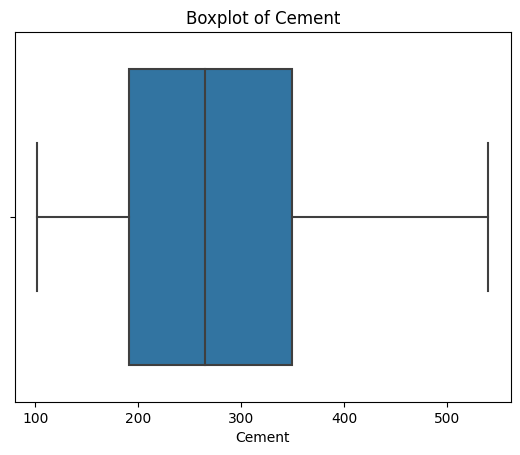

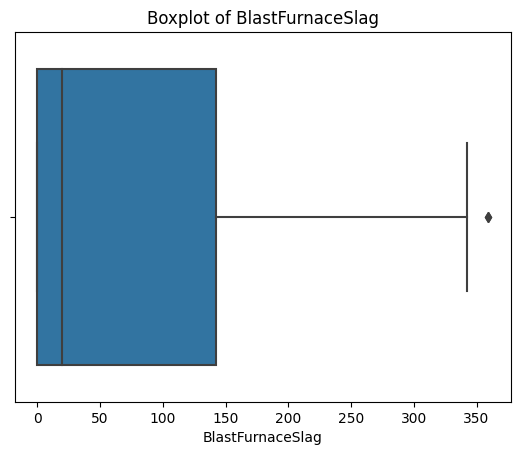

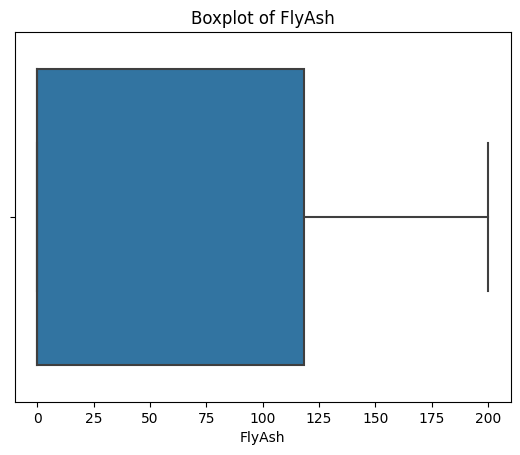

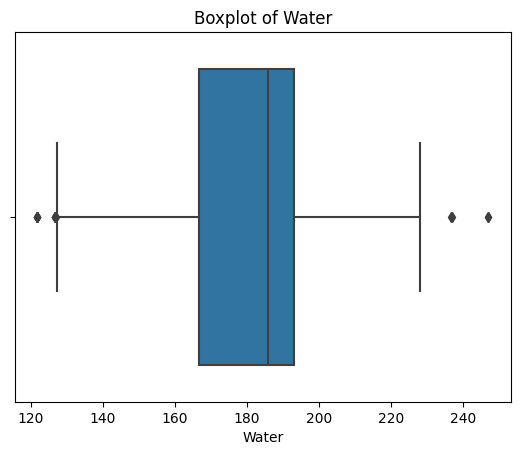

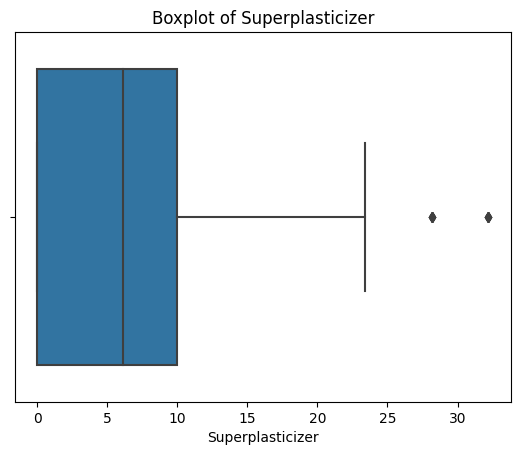

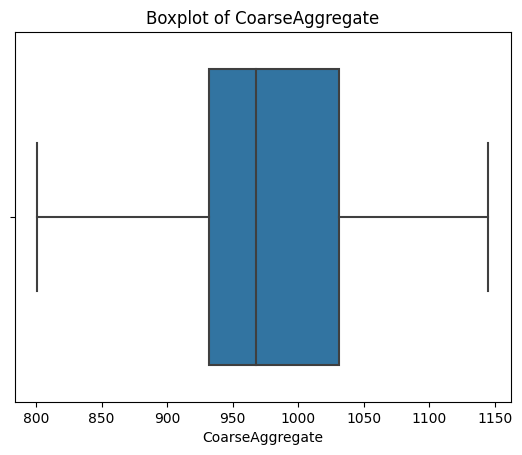

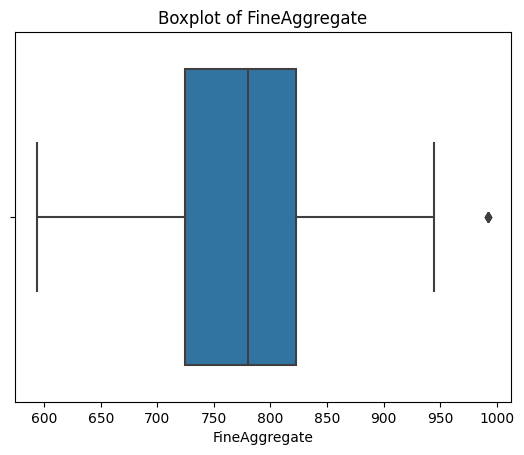

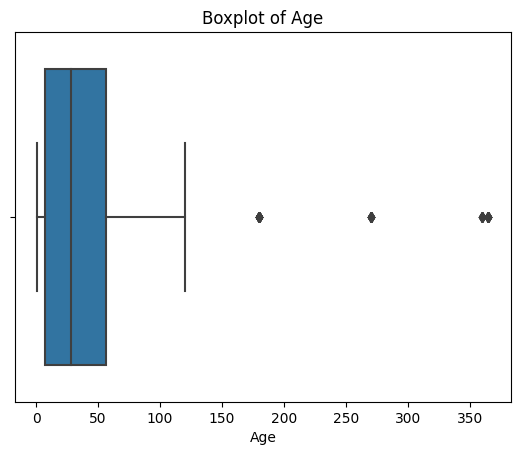

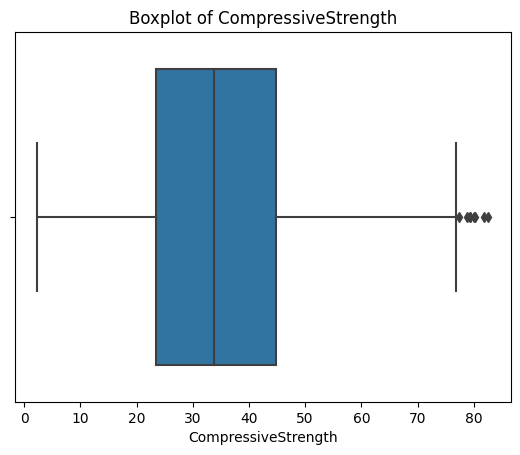

In [ ]:
#boxplots univariate
for col in ccs_final.columns:
      plt.figure()
      sns.boxplot(data=ccs_final, x=col)
      plt.title(f"Boxplot of {col}")
      plt.show()

For the time being I'll keep records with outliers, but experimentation in feature engineering is definitely on the table to improve model performance.

In [ ]:
#unique values (checking for too much stability)
print(ccs_final.nunique())

Cement                 280
BlastFurnaceSlag       187
FlyAsh                 163
Water                  205
Superplasticizer       155
CoarseAggregate        284
FineAggregate          304
Age                     14
CompressiveStrength    938
dtype: int64


It looks like there isn't too much stability in our columns. If there was too much stability say around only 4 or 5 for age, dropping the column may have been better for our model's health.

In [ ]:
#if we need to drop some records a for loop that rotates through all columns may be necessary
ccs_final[np.abs(stats.zscore(ccs_final['CompressiveStrength'])) <= 3].sort_values(by='CompressiveStrength', ascending=False)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
181,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.599225
381,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.751169
153,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.199848
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
159,389.9,189.0,0.0,145.9,22.0,944.7,755.8,56,79.400056
...,...,...,...,...,...,...,...,...,...
717,141.3,212.0,0.0,203.5,0.0,971.8,748.5,3,4.827711
668,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3,4.782206
652,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.565021
705,122.6,183.9,0.0,203.5,0.0,958.2,800.1,3,3.319827


## Correlation Matrix

<Axes: >

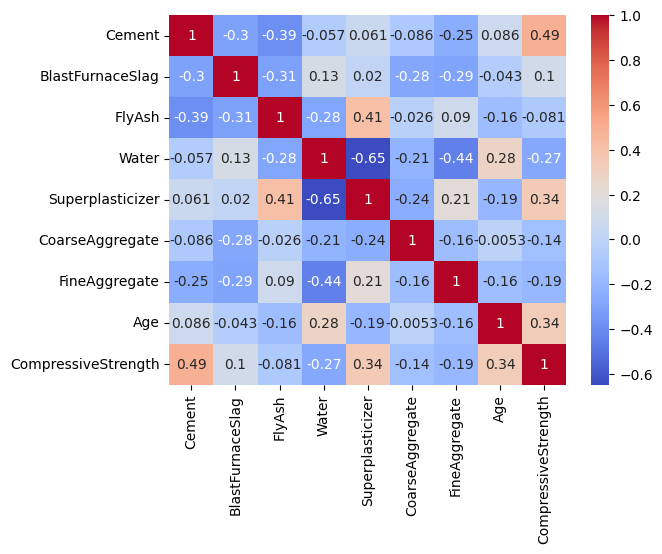

In [ ]:
corr = ccs_final.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

Lets sort some of our more important correlations with compressive strength.

In [ ]:
#create correlations with CompressiveStrength
correlations = ccs_final.drop("CompressiveStrength", axis=1).apply(lambda x: x.corr(ccs_final.CompressiveStrength, method='spearman'))

#sort the correlations in descending order
correlations.sort_values(ascending=False)

Age                 0.605397
Cement              0.461397
Superplasticizer    0.321815
BlastFurnaceSlag    0.138626
FlyAsh             -0.056457
CoarseAggregate    -0.162843
FineAggregate      -0.193319
Water              -0.284214
dtype: float64

Some interesting correlations between age and compressive strength, cement and compressive strength, superplasticizer and compressive strength, water and superplasticizer, and water and fine aggregate. Lets explore them using some visualizations.

## Bivariate Analysis

<Axes: xlabel='Age', ylabel='CompressiveStrength'>

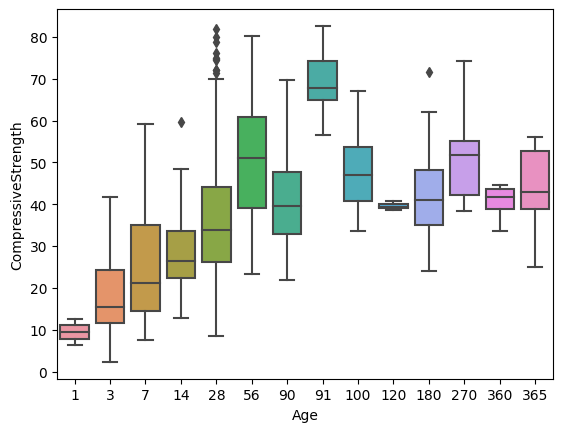

In [ ]:
#opted for a boxplot since age is essentially binned
sns.boxplot(x="Age", y="CompressiveStrength", data=ccs_final)

Here we see the leveling off of compressive strength as age (in days) progresses past 30.

<Axes: xlabel='Cement', ylabel='CompressiveStrength'>

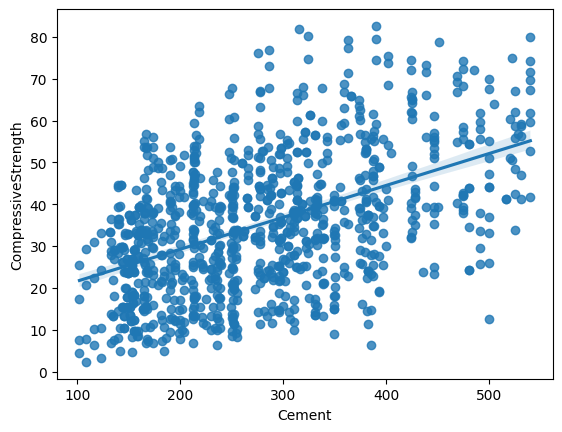

In [ ]:
sns.regplot(x="Cement", y="CompressiveStrength", data=ccs_final)

Interesting to see some linearity between cement and compressive strength considering the supposed non-linearity of this dataset.

<Axes: xlabel='Superplasticizer', ylabel='CompressiveStrength'>

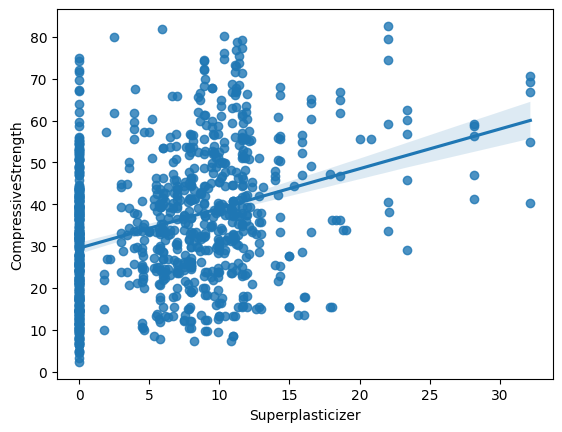

In [ ]:
sns.regplot(x="Superplasticizer", y="CompressiveStrength", data=ccs_final)

Here's a better example of the non-linearity of our dataset within the relationship of superplasticizer and compressive strength. There is a definite lack of homogenuity within our dataset. This is most likely a result of the front loading we saw in our histograms earlier.

<Axes: xlabel='Superplasticizer', ylabel='Water'>

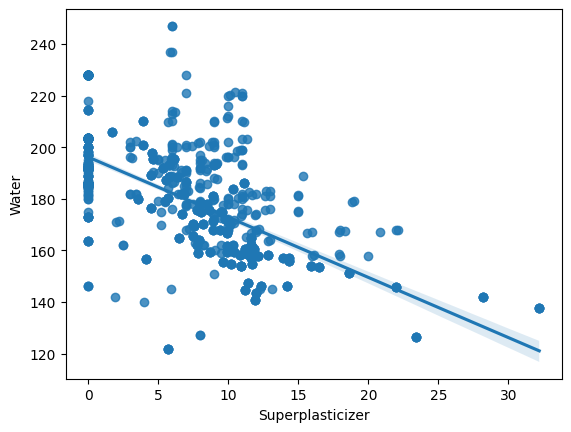

In [ ]:
sns.regplot(x="Superplasticizer", y="Water", data=ccs_final)

<Axes: xlabel='Water', ylabel='FineAggregate'>

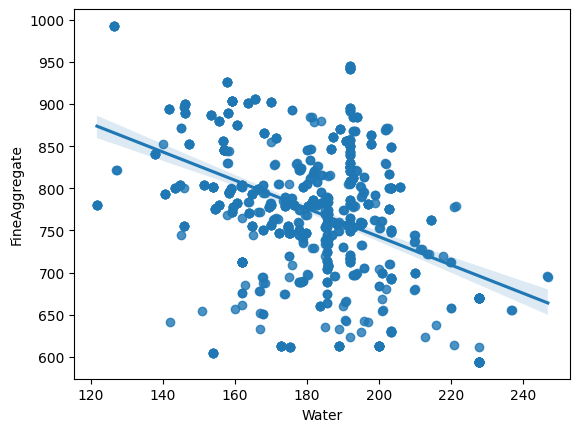

In [ ]:
sns.regplot(x="Water", y="FineAggregate", data=ccs_final)

Despite water being essential in our process, it shares a negative correlation with almost all of our variables. Perhaps the addition of blast furnace slag (the only componenet that shares a positive relationship with water) can assist in curving this when searching for an optimal mix.

# Feature Engineering

In [ ]:
#test/train split w/ outliers
X_train_ccs, X_test_ccs, y_train_ccs, y_test_ccs= train_test_split (
    ccs_final.iloc[:,:-1], ccs_final.iloc[:,-1], test_size=0.2,
     random_state=42)

Outliers previously seen create some uncertainty with our data. Are the outliers we see input errors/data corruption, or are they simply true outliers. Since the answer to our question would require a much more intimate knowledge of the process by which these data points were recorded, we will treat these outliers as a variation of our dataset. However neural networks becomes biased much more easily by outliers than our ensemble and gradiant methods. Let's also create variations of our dataset without outliers.

In [ ]:
#new df w/o outliers
ccs_final_nout= ccs_final[(np.abs(stats.zscore(ccs_final)) <= 3).all(axis=1)]

ccs_final_nout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               956 non-null    float64
 1   BlastFurnaceSlag     956 non-null    float64
 2   FlyAsh               956 non-null    float64
 3   Water                956 non-null    float64
 4   Superplasticizer     956 non-null    float64
 5   CoarseAggregate      956 non-null    float64
 6   FineAggregate        956 non-null    float64
 7   Age                  956 non-null    int64  
 8   CompressiveStrength  956 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 74.7 KB


In [ ]:
#while I thought about winsorizing our data set. For this specific case it did not make sense.
#there is no reason to assume our values are false nor is there an excess of outliers

#Let's create a new dataframe where we winsorize our outliers
#limits = [0.05, 0.05] #top and bottom 10%
#winsorized_ccs = pd.DataFrame()

#for col in ccs_final.columns:
#    winsorized_ccs[col] = winsorize(ccs_final[col], limits=limits)

Since we'll be working with deep learning, it is prudent to create a set of scaled splits as we'll be needing them later for testing. I'll also be making a normalized split.

In [ ]:
#test/train split w/o outliers
#nout is short for no outliers
X_train_ccs_nout, X_test_ccs_nout, y_train_ccs_nout, y_test_ccs_nout= train_test_split (
    ccs_final_nout.iloc[:,:-1], ccs_final_nout.iloc[:,-1],
     test_size=0.2, random_state=42)

In [ ]:
#splitting X and y
X = ccs_final.iloc[:,:-1]
y = ccs_final.iloc[:,-1]

X_nout = ccs_final_nout.iloc[:,:-1]
y_nout = ccs_final_nout.iloc[:,-1]

In [ ]:
#standardization
standard = StandardScaler()

#w/ outliers
X_stand = standard.fit_transform(X)
X_train_ccs_stand, X_test_ccs_stand, y_train_ccs_stand, y_test_ccs_stand= train_test_split (
    X_stand, y, test_size=0.2, random_state=42)

#w/o outliers
X_nout_stand = standard.fit_transform(X_nout)
X_train_ccs_nout_stand, X_test_ccs_nout_stand, y_train_ccs_nout_stand, y_test_ccs_nout_stand= train_test_split (
    X_nout_stand, y_nout, test_size=0.2, random_state=42)

In [ ]:
#min max scaling
mm_scaler = MinMaxScaler()

#w/ outliers
X_mm_scaled = mm_scaler.fit_transform(X)
X_train_ccs_mm_scaled, X_test_ccs_mm_scaled, y_train_ccs_mm_scaled, y_test_ccs_mm_scaled=train_test_split (
    X_mm_scaled, y, test_size=0.2, random_state=42)

#w/o outliers
X_nout_mm_scaled = mm_scaler.fit_transform(X_nout)
X_train_ccs_nout_mm_scaled, X_test_ccs_nout_mm_scaled, y_train_ccs_nout_mm_scaled, y_test_ccs_nout_mm_scaled= train_test_split (
    X_nout_mm_scaled, y_nout, test_size=0.2, random_state=42)

In [ ]:
#normalized
normalizer = Normalizer()

#w/ outliers
X_norm = normalizer.fit_transform(X)
X_train_ccs_norm, X_test_ccs_norm, y_train_ccs_norm, y_test_ccs_norm=train_test_split (
    X_norm, y, test_size=0.2, random_state=42)

#w/o outliers
X_nout_norm = normalizer.fit_transform(X_nout)
X_train_ccs_nout_norm, X_test_ccs_nout_norm, y_train_ccs_nout_norm, y_test_ccs_nout_norm= train_test_split (
    X_nout_norm, y_nout, test_size=0.2, random_state=42)

# <center>Regression Harness

Let's define some variables to use for cross validation in our models.

In [ ]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scoring = 'neg_mean_squared_error'

LR: -103.416627 (14.309652)
Score for each of the 10 K-fold tests:  [-113.78724053  -91.4670907   -95.21804763 -109.72045779  -76.65148173
 -129.47853791  -92.20856548 -106.56462201 -116.02998812 -103.04024042]
LinearRegression()
	Training time: 0.004s
	Prediction time: 0.088s

LASSO: -103.474021 (14.074931)
Score for each of the 10 K-fold tests:  [-114.25638424  -91.341341    -95.28062937 -109.92396986  -76.50081693
 -127.49132421  -92.82373893 -107.33415478 -116.7385576  -103.04929675]
Lasso()
	Training time: 0.003s
	Prediction time: 0.070s

EN: -103.425187 (14.159990)
Score for each of the 10 K-fold tests:  [-114.04872813  -91.40750155  -95.21199618 -109.84491262  -76.47617612
 -128.16298749  -92.56313114 -107.02777776 -116.45553967 -103.0531187 ]
ElasticNet()
	Training time: 0.010s
	Prediction time: 0.174s

KNN: -92.821587 (17.303308)
Score for each of the 10 K-fold tests:  [ -81.92528232  -98.72188664 -110.70937242  -72.34210726  -58.24077226
 -106.65806801  -95.77379389  -95.0343

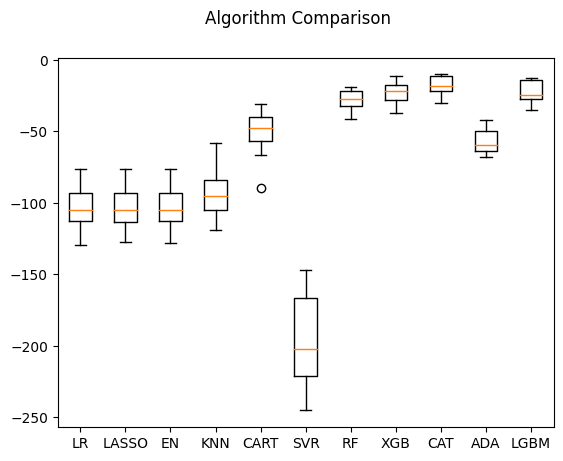

In [ ]:
#model list
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RF', RandomForestRegressor()))
models.append(('XGB', XGBRegressor(objective='reg:squarederror')))
models.append(('CAT', CatBoostRegressor(verbose=0)))
models.append(('ADA', AdaBoostRegressor()))
models.append(('LGBM',LGBMRegressor()))

#evaluate each model in turn
results = []
names = []
for name, model in models:
    start = time()
    model.fit(X_train_ccs, y_train_ccs)
    train_time = time() - start
    #standard data w/ outliers for cv
    cv_results = cross_val_score(model, X_train_ccs, y_train_ccs,
                                 cv=kfold, scoring=scoring)
    predict_time = time()-start
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("Score for each of the 10 K-fold tests: ",cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()

#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From our harness we quickly see that our best models are ensembles (gradients and forests). From these enambles our best performers where CATBoost, LightGBM, XGBoost, and Regression Forests. We'll stick to XGBoost (since CATBoost prediction time is quite a bit), a regression forest, and our neural network.

Let's start with a regression forest since it gave us the highest MSE. We'll run our models through a battery of tests to ensure that our train/test split isn't hurting model performance.

# <center>Regression Forest

## Baseline

In [ ]:
#baseline model
rf_ccs = RandomForestRegressor(random_state=42)

In [ ]:
#train model
rf_ccs.fit(X_train_ccs, y_train_ccs)

RandomForestRegressor(random_state=42)

In [ ]:
#test model
mean_squared_error(y_test_ccs, rf_ccs.predict(X_test_ccs))

26.25594974528681

Our baseline performed as expected. Lets run a quick test to ensure all our columns are being utilized and not creating noise in our model.

### Feature Importance

In [ ]:
#create feature importance comparison (column name w/ coeffcients)
feature_imp_rf = pd.Series(
    rf_ccs.feature_importances_,
    ccs_final.iloc[:,:-1].columns [rf_ccs.feature_importances_!=0])
feature_imp_rf.sort_values(ascending=False)

Age                 0.360787
Cement              0.302152
Superplasticizer    0.091269
Water               0.084314
BlastFurnaceSlag    0.072175
FineAggregate       0.045936
CoarseAggregate     0.026878
FlyAsh              0.016490
dtype: float64

Our columns are indeed influencing our model. Its possible that dropping flyash could ever so slightly change our results, but more impactful measures like hyperparameter tuning should be our focus.

Text(0.5, 0, 'RandomForestRegressor Feature Importance')

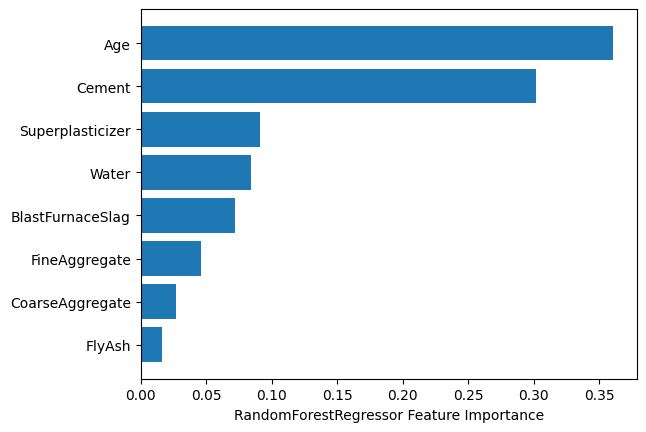

In [ ]:
#desc sorting bar chart for feature importance
sorted_idx = rf_ccs.feature_importances_.argsort()
plt.barh(
    ccs_final.columns[sorted_idx],
    rf_ccs.feature_importances_[sorted_idx])
plt.xlabel("RandomForestRegressor Feature Importance")

Let's try our Regression Forest without outliers.

## w/o Outliers

In [ ]:
#model w/o outliers
rf_ccs_nout = RandomForestRegressor(random_state=42)

In [ ]:
#train model
rf_ccs_nout.fit(X_train_ccs_nout, y_train_ccs_nout)

RandomForestRegressor(random_state=42)

In [ ]:
#test model
mean_squared_error(y_test_ccs_nout, rf_ccs_nout.predict(X_test_ccs_nout))

26.209738088391827

Our model without outliers is slightly better than with outliers. Let's stick w/o outliers moving forward.

## Standardized

In [ ]:
#pipelining standard scaling with random forest
pipe_ccs_rf_scaled = make_pipeline(StandardScaler(),
                                   RandomForestRegressor(random_state=42))

In [ ]:
#train model via pipe
pipe_ccs_rf_scaled.fit(X_train_ccs_nout, y_train_ccs_nout)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
#test model via pipe
mean_squared_error(y_test_ccs_nout, pipe_ccs_rf_scaled.predict(X_test_ccs_nout))

26.22595646092259

It seems standardization made no difference in our model's performance. This to be expected with trees though since trees are not sensitive to the scale of data. Let's move on to hyperparameter tuning. We'll test normalization as well, but standardization doesn't give me much hope that normalization will benefit our model.

## Min Max Scaled

In [ ]:
#pipelining min max scaled with random forest
pipe_ccs_rf_mm_scaled = make_pipeline(MinMaxScaler(),
                                 RandomForestRegressor(random_state=42))

In [ ]:
#train model via pipe
pipe_ccs_rf_mm_scaled.fit(X_train_ccs_nout, y_train_ccs_nout)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
#test model via pipe
mean_squared_error(y_test_ccs_nout, pipe_ccs_rf_mm_scaled.predict(X_test_ccs_nout))

26.230851373720487

We get similar results to standardization if not a little worse. Let's test our last split.

## Normalized

In [ ]:
#pipelining normalization with random forest
pipe_ccs_rf_norm = make_pipeline(Normalizer(),
                                 RandomForestRegressor(random_state=42))

In [ ]:
#train model via pipe
pipe_ccs_rf_norm.fit(X_train_ccs_nout, y_train_ccs_nout)

Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
#test model via pipe
mean_squared_error(y_test_ccs_nout, pipe_ccs_rf_norm.predict(X_test_ccs_nout))

26.910219239684313

Looks like we'll be sticking with our normal split without outliers.

## Theory Based Tuning

### Hyperparameter Tuning

In [ ]:
#assortment of trees
number_of_trees=np.arange(50,501,10)

In [ ]:
#prints number of columns and square root of number of columns
print(X_train_ccs.shape[1])
print(np.sqrt(X_train_ccs_nout.shape[1]))

8
2.8284271247461903


In [ ]:
#create arrangement of possible feature based off columns and columns sq root
number_of_features=np.arange(2,5)

#create an empty numpy array based off trees/feature arrangments
mse_scores_rf_oob_matrix= np.empty((number_of_features.size,
                                    number_of_trees.size))
mse_scores_rf_oob_matrix.shape

(3, 46)

In [ ]:
#essentially a gridsearch but certain parameters are reduced because of existing information
r=0
for i in number_of_features:
  c=0
  for j in number_of_trees:
    rf_loop= RandomForestRegressor(n_estimators = j, oob_score= True,
                                   max_features=i, random_state=42)
    rf_loop.fit(X_train_ccs_nout, y_train_ccs_nout)
    mse_scores_rf_oob_matrix[r,c]= mean_squared_error(y_train_ccs_nout,
                                                      rf_loop.oob_prediction_)
    c=c+1
  r= r+1

In [ ]:
#number of features to use
number_of_features[np.where(mse_scores_rf_oob_matrix == np.min(
    mse_scores_rf_oob_matrix))[0]]

array([4])

In [ ]:
#ensemble of trees to use
number_of_trees[np.where(
    mse_scores_rf_oob_matrix == np.min(mse_scores_rf_oob_matrix))[1]]

array([130])

### Train and Test

In [ ]:
#theory based model using tuned features and trees
rf_ccs_tb= RandomForestRegressor(n_estimators= 130, max_features=4,
                                 random_state=42)

In [ ]:
#train theory based model
rf_ccs_tb.fit(X_train_ccs_nout, y_train_ccs_nout)

RandomForestRegressor(max_features=4, n_estimators=130, random_state=42)

In [ ]:
#test theory based model
mean_squared_error(y_test_ccs_nout, rf_ccs_tb.predict(X_test_ccs_nout))

24.112557880767582

The theory based approach for hyparameter tuning resulted in slightly better numbers to our baseline model. Let's tune hyperparameters using a practice based approach.

## Practice Based Tuning

### Hyperparameter Tuning

To speed up our hyparameter tuning we'll use Bayesian Optimization from scikit optomize.

In [ ]:
#create parameters
search_space_rf = {
    'n_estimators': (10, 500, 20),
    'max_features': (2, 8),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

In [ ]:
#bayesian optimization using parameters previously defined
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

bayes_rf_tuner = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                               search_spaces=search_space_rf, n_iter=32,
                               cv=kfold,
                               verbose=2,n_jobs=-1,scoring=scoring,
                               random_state=42)

In [ ]:
#fit training data uisng CV to bayesion tuner
bayes_rf_tuner.fit(X_train_ccs_nout, y_train_ccs_nout)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=RandomForestRegressor(random_state=42), n_iter=32,
              n_jobs=-1, random_state=42, scoring='neg_mean_squared_error',
              search_spaces={'max_features': (2, 8),
                             'min_samples_leaf': (1, 10),
                             'min_samples_split': (2, 10),
                             'n_estimators': (10, 500, 20)},
              verbose=2)

In [ ]:
#best hyperparameters according to bayesion tuner
print(bayes_rf_tuner.best_params_)

OrderedDict([('max_features', 6), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])


### Train and Test

In [ ]:
#create mode with hyperparams from bayesian tuner
rf_ccs_pb= RandomForestRegressor(
    max_features=bayes_rf_tuner.best_params_['max_features'],
    min_samples_leaf=bayes_rf_tuner.best_params_['min_samples_leaf'],
    min_samples_split = bayes_rf_tuner.best_params_['min_samples_split'],
    n_estimators=bayes_rf_tuner.best_params_['n_estimators'], random_state=42)

In [ ]:
#train practice model
rf_ccs_pb.fit(X_train_ccs_nout, y_train_ccs_nout)

RandomForestRegressor(max_features=6, n_estimators=500, random_state=42)

In [ ]:
#test practice model
mean_squared_error(y_test_ccs_nout, rf_ccs_pb.predict(X_test_ccs_nout))

24.817391263755834

Our theory based approach outperformed our practice based model. Ultimately which of these two results in the best performance is typically determined by the dataset.

## Conclusion

While Outliers likely won't be a problem for neither our ensemble methods, since they are trees, the lack of outliers assisted in finding a slightly more accurate model. While our base model performed excellent it was outperformed by our theory based model. Nothing too astounding, but we're definitely off to a good start if our forest method resulted in such a low MSE.

Lets explore the RMSE of our tuned model to get a better idea of how our model performs practically.

In [ ]:
#average of compressive strength
ccs_final.iloc[:,-1].mean()

35.25027287623583

In [ ]:
#RMSE
RMSE_rf = mean_squared_error(y_test_ccs_nout,
                             rf_ccs_tb.predict(X_test_ccs_nout),
                             squared = False)
RMSE_rf

4.9104539383612575

In [ ]:
RMSE_rf*2

9.820907876722515

Let's remind ourselves that RMSE is essentially a standard deviation of how our models predictions relate to the actual values. Since our RMSE is 4.91 68% of predicitons will be within +/- 4.91 of the actual values, and 95% of predicitons will be within +/- 9.82 (RMSE * 2) of the actual values.

Overall when compared to the average compressive strength its not a bad value, but our gradiant method in XGBoost should outperform it.

# <center>XGBoost

## Baseline

In [ ]:
#base model
xgb_ccs = XGBRegressor(random_state=42)

In [ ]:
#train base model
xgb_ccs.fit(X_train_ccs, y_train_ccs)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
#test base model
mean_squared_error(y_test_ccs, xgb_ccs.predict(X_test_ccs))

20.01054650716039

Definitely some better performance than our Random Forest models. Like previously now that we've set our baseline lets check feature importance then test XGBoost on our dataset w/o outliers.

## Feature Importance

In [ ]:
#defining feature importance descending for XGBoost
feature_imp_rf = pd.Series(xgb_ccs.feature_importances_,
                           ccs_final.iloc[:,:-1].columns [xgb_ccs.feature_importances_!=0])
feature_imp_rf.sort_values(ascending=False)

Age                 0.261749
Cement              0.217487
Superplasticizer    0.147318
BlastFurnaceSlag    0.138124
Water               0.115098
FineAggregate       0.056405
FlyAsh              0.033407
CoarseAggregate     0.030411
dtype: float32

Text(0.5, 0, 'XGBoostRegressor Feature Importance')

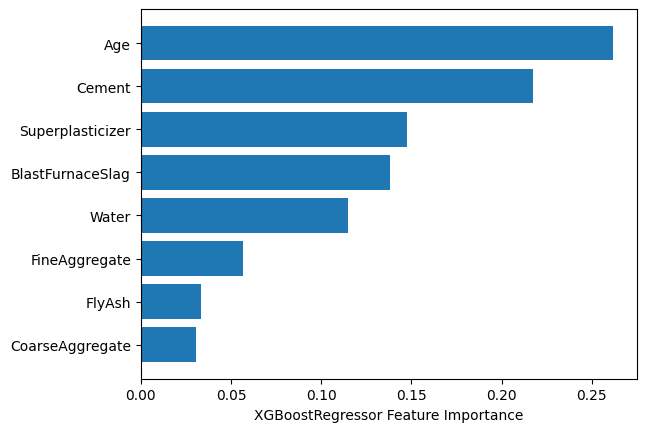

In [ ]:
#desc sorting bar chart for feature importance
sorted_idx = xgb_ccs.feature_importances_.argsort()
plt.barh(
    ccs_final.columns[sorted_idx],
    xgb_ccs.feature_importances_[sorted_idx])
plt.xlabel("XGBoostRegressor Feature Importance")

All seemse well with our feature importance. XGBoost has determined that CoarseAggregate has less importance than FlyAsh (the inverse of regression forest).

## w/o Outliers

In [ ]:
#nout model
xgb_ccs_nout = XGBRegressor(random_state=42)

In [ ]:
#training nout model
xgb_ccs_nout.fit(X_train_ccs_nout, y_train_ccs_nout)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
#mse for nout model
mean_squared_error(y_test_ccs_nout, xgb_ccs_nout.predict(X_test_ccs_nout))

17.413971793598737

Again we see outliers having an impact on our models. Let's swap out our data for a standardized and normalized version to ensure that we work with the best possible conditions.

## Standardized

In [ ]:
#pipe with standard scaling and xgoost
pipe_ccs_xgb_scaled = make_pipeline(StandardScaler(),
                                    XGBRegressor(random_state=42))

In [ ]:
#training model in pipe
pipe_ccs_xgb_scaled.fit(X_train_ccs_nout, y_train_ccs_nout)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [ ]:
#mse for our standardized model
mean_squared_error(y_test_ccs_nout, pipe_ccs_xgb_scaled.predict(X_test_ccs_nout))

17.419885094317774

Standardization unfortunately didn't improve our model. Let's try more scaling and normalization before moving on to hyperparameter tuning.

## Min Max Scaled

In [ ]:
#pipe with min max scaling and xgoost
pipe_ccs_xgb_mm_scaled = make_pipeline(MinMaxScaler(), XGBRegressor(random_state=42))

In [ ]:
#training model in pipe
pipe_ccs_xgb_mm_scaled.fit(X_train_ccs_nout, y_train_ccs_nout)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [ ]:
#mse for our min max scaled model
mean_squared_error(y_test_ccs_nout, pipe_ccs_xgb_mm_scaled.predict(X_test_ccs_nout))

17.418063357607277

Our model yet again did not care for our attempts to improve its performance using min max scaling. Let's try normalization.

## Normalized

In [ ]:
#pipe with normalization and xgoost
pipe_ccs_xgb_norm = make_pipeline(Normalizer(), XGBRegressor(random_state=42))

In [ ]:
#training model in pipe
pipe_ccs_xgb_norm.fit(X_train_ccs_nout, y_train_ccs_nout)

Pipeline(steps=[('normalizer', Normalizer()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])

In [ ]:
#mse for our normalized model
mean_squared_error(y_test_ccs_nout, pipe_ccs_xgb_norm.predict(X_test_ccs_nout))

19.390620618856847

Our model got even worse. Let's stick to our standard split with no outliers.

## Tuning

### Hyperparameter Tuning

In [ ]:
#search params
search_space_xgb = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (10, 1000),
    'max_depth': (1, 50),
    'gamma': (0.0, 1.0),
    'subsample': (0.01, 1.0),
    'colsample_bytree': (0.01, 1.0),
    'reg_alpha': (1e-9, 1000),
    'reg_lambda': (1e-9, 1000)
}

In [ ]:
#define folds
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

#bayesian optimizer
bayes_xgb_tuner = BayesSearchCV(estimator=XGBRegressor(random_state=42),
                               search_spaces=search_space_xgb, n_iter=32,
                                cv=kfold,
                               verbose=2,n_jobs=-1,scoring=scoring,
                                random_state=42)

In [ ]:
#fit optimizer
bayes_xgb_tuner.fit(X_train_ccs_nout, y_train_ccs_nout)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     in...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
              n_iter=32, n_jobs=-1, random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'colsample_bytree': (0.01, 1.0),
                             'gamma': (0.0, 1.0), 'learning_rate': (0.01, 1.0),
                             'max_depth': (1, 50), 'n_estimators': (10, 1000),
                             'reg_alpha': (1e-09, 1000),
                             'reg_lambda': (1e-09, 1000),
                             'subsample': (0.01, 1.0)},
              verbose=2)

In [ ]:
#best params for xgboost
bayes_xgb_tuner.best_params_

OrderedDict([('colsample_bytree', 0.8906935884880257),
             ('gamma', 0.8257986268868158),
             ('learning_rate', 0.4943502498378257),
             ('max_depth', 17),
             ('n_estimators', 903),
             ('reg_alpha', 1e-09),
             ('reg_lambda', 176.56564439251497),
             ('subsample', 0.4285367577316468)])

### Train and Test

In [ ]:
#create model with best params
xgb_ccs_tune = XGBRegressor(colsample_bytree=bayes_xgb_tuner.best_params_['colsample_bytree'],
                           gamma=bayes_xgb_tuner.best_params_['gamma'],
                           learning_rate=bayes_xgb_tuner.best_params_['learning_rate'],
                           max_depth=bayes_xgb_tuner.best_params_['max_depth'],
                           n_estimators=bayes_xgb_tuner.best_params_['n_estimators'],
                           reg_alpha=bayes_xgb_tuner.best_params_['reg_alpha'],
                           reg_lambda=bayes_xgb_tuner.best_params_['reg_lambda'],
                           subsample=bayes_xgb_tuner.best_params_['subsample'],
                           random_state=42)

In [ ]:
#train tuned model
xgb_ccs_tune.fit(X_train_ccs_nout, y_train_ccs_nout)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8906935884880257, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.8257986268868158, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.4943502498378257, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=903, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
#mse for our tuned model
mean_squared_error(y_test_ccs_nout, xgb_ccs_tune.predict(X_test_ccs_nout))

12.008439183392445

Thats's some excellent performance! There is some variability to be found due to shifts in hyperparameters, but nonetheless the MSE finds itself around 12 to 15 consistently.

## Conclusion

Our tuned model is performing much better than our base model. This will likely be our best performer due to the size of our dataset, but we'll be prudent and test deep learning. Before moving on to our neural network lets compare RMSE to ground our work.

In [ ]:
#average of compressive strength
ccs_final_nout.iloc[:,-1].mean()

34.68376069046131

In [ ]:
#random forest rmse
RMSE_rf

4.9104539383612575

In [ ]:
#2 times random forest rmse
2 * RMSE_rf

9.820907876722515

In [ ]:
#xgboost rmse
RMSE_xgb = mean_squared_error(y_test_ccs_nout,
                              xgb_ccs_tune.predict(X_test_ccs_nout),
                              squared=False)
RMSE_xgb

3.465319492253556

In [ ]:
#2 times xgboost rmse
2 * RMSE_xgb

6.930638984507112

Since RMSE is the variability of our models predicited variables. Our XGBoost model with tuned hyperparameters has 68% of predicting within +/- RMSE of the actual values and 95% of predictions within a +/- of RMSE * 2. Compared to our previous 4.91 and 9.82 that is about a 30% reduction in error. The three most important features for both models are supported by our correlation matrix (age, cement, and superplasticizer).

Lastly we'll be testing this dataset with a neural network. The limited size of this dataset may be problematic for the neural network, but let's hope that we could walk away with even better performance.

# <center>Deep Learning

Let's start in typical fashion and set up a base model for our NN. We'll be defaulting to using scaling since deep learning requires some form of normalization. We also will be incorperating cross validation since the randomization of weights within our model can sometimes cause us to come to poor conclusions. In order to perform these calculations we'll be using the following code throught the majority of our deep learning.

In [ ]:
#scoring and folding standards
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
#stops getting stuck on saddles uses val data
val_cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.01,
    patience=10,
    verbose=1,
    min_lr=0.00001
)

In [ ]:
#stops training poor model uses val data
val_cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.001,
    patience=20,
    verbose=1
)

In [ ]:
#saves good models and compares them to our previous saves uses val data
val_cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/model-{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [ ]:
#saves data of our epochs
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename='training_log.csv',
    separator=',',
    append=False
)

I'll include some version that are not dependant on validation data since they can be used to speed up training for poor performing models during the tuning phase.

In [ ]:
#stops getting stuck on saddles
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    mode='min',
    factor=0.01,
    patience=10,
    verbose=1,
    min_lr=0.00001
)

In [ ]:
#stops training poor model uses val data
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    min_delta=0.001,
    patience=15,
    verbose=1
)

## Base Model

In [ ]:
#create base model
def base_model():
    base_model_ccs = Sequential([
        Dense(32, activation='relu', kernel_initializer='he_normal',
              input_shape=(X_train_ccs_stand.shape[1],)),
        Dense(1) #regression doesn't need an activation function
    ])

    base_model_ccs.compile(loss='mse',
                       optimizer=Adam(learning_rate=.001), metrics=['mae',
                                                                    RSquare()])
    return base_model_ccs

#wrap base model
base_model_ccs_wrapper = KerasRegressor(build_fn=base_model, epochs=100,
                                        batch_size=32, verbose=0)

#test base using cv
cv_results_base = cross_val_score(base_model_ccs_wrapper, X_train_ccs_stand,
                                  y_train_ccs_stand,
                                  cv=kfold, scoring=scoring)

In [ ]:
#results
print(-cv_results_base.mean())

141.80868096960853


If your confused about the large MSE, I've opted to start with an extremely simple NN as to exasturbate the improvements each change makes in our model. While this serves to display a gradient like affect of beginning poorly and ending with a high functioning neural network, the purpose is in the exasturbation itself. When the differneces of these models are expanded, it is more difficult to attach the value of what we've done to randomness within the weights of our model versus the change itself.

## w/o Outliers

In [ ]:
#create model w/o outliers
def nout_model():
    nout_model_ccs = Sequential([
        Dense(32, activation='relu', kernel_initializer='he_normal',
              input_shape=(X_train_ccs_stand.shape[1],)),
        Dense(1)
    ])

    nout_model_ccs.compile(loss='mse',
                       optimizer=Adam(learning_rate=.001),
                        metrics=['mae', RSquare()])
    return nout_model_ccs

#wrap model
nout_model_ccs_wrapper = KerasRegressor(build_fn=nout_model, epochs=100,
                                        batch_size=32, verbose=0)

#test model using cv
cv_results_nout = cross_val_score(nout_model_ccs_wrapper,
                                  X_train_ccs_nout_stand,
                                  y_train_ccs_nout_stand,
                                  cv=kfold, scoring=scoring)

In [ ]:
#results
print(-cv_results_nout.mean())

125.63679487092129


Our model has improved quite a bit w/o outliers. All seems well since it's well known that neural networks are sensitive to outliers and unscaled data. Let's try one more model where we normalize instead of scale.

## Min Max Scaled

In [ ]:
#create model with mm data
def mm_scaled_model():
    mm_scaled_model_ccs = Sequential([
        Dense(32, activation='relu', kernel_initializer='he_normal',
              input_shape=(X_train_ccs_nout_mm_scaled.shape[1],)),
        Dense(1)
    ])

    mm_scaled_model_ccs.compile(loss='mse',
                       optimizer=Adam(learning_rate=.001), metrics=['mae',
                                                                    RSquare()])
    return mm_scaled_model_ccs

#wrap data
mm_scaled_model_ccs_wrapper = KerasRegressor(build_fn=mm_scaled_model,
                                             epochs=100, batch_size=32,
                                             verbose=0)

#test model with cv
cv_results_mm_scaled = cross_val_score(mm_scaled_model_ccs_wrapper,
                                       X_train_ccs_nout_mm_scaled,
                                       y_train_ccs_nout_mm_scaled,
                                       cv=kfold, scoring=scoring)

In [ ]:
#results
print(-cv_results_mm_scaled.mean())

113.47191550680914


Excellent it seems that the min max scaled data performs better than the scaled data. Perhaps the negative values from standardization leave some room for improvement especially considering the relu activation functions.

## Normalized

In [ ]:
#create model with normalized data
def norm_model():
    norm_model_ccs = Sequential([
        Dense(32, activation='relu', kernel_initializer='he_normal',
              input_shape=(X_train_ccs_nout_norm.shape[1],)),
        Dense(1)
    ])

    norm_model_ccs.compile(loss='mse',
                       optimizer=Adam(learning_rate=.001), metrics=['mae',
                                                                    RSquare()])
    return norm_model_ccs

#wrap model
norm_model_ccs_wrapper = KerasRegressor(build_fn=norm_model, epochs=100,
                                        batch_size=32, verbose=0)

#test model with cv
cv_results_norm = cross_val_score(norm_model_ccs_wrapper, X_train_ccs_nout_norm,
                                  y_train_ccs_nout_norm,
                                  cv=kfold, scoring=scoring)

In [ ]:
#results
print(-cv_results_norm.mean())

241.28514822072913


Seems we'll be sticking to min max scaling.

## <center>Tuning

### Hyperparameter Tuning Functions

As you take a look at the possible permutations of a search space you'll notice that the kernel and activation functions are not flooded with different possibilities. The reason for this is simple. Flooding the bayesian search is not only costly and would result in you having to spend more time waiting for your results, but it also typically brought about an odd mix of parameters that overfit our model despite the use of cross validation (likely because of the skew averages have towards outliers). It is best in this case to stick to the simple methodology of selecting a few kernels and activators that perform generally well for your use case. This creates a strong model once validation takes place.

As a counterpoint to the above, perhaps the size of my data for this specific use case invalidated my "larger" tuner. Either way, more experimentation with the following code is necessary and requires larger and more varied data to form solid conclusions on.

An issue with efficiency: When "layers" is being tuned BayesSearchCV is likely creating some redundency since the parameters in the other layers are still being tuned. I suspect a manual version of Bayes will still outperform this, but nonetheless this is a quick version to implement.

In [ ]:
#things to change
max_layers = 5
output_layer = Dense(1)
input_shape = (X_train_ccs_nout_mm_scaled.shape[1],)

In [ ]:
#function to build search parameters
def build_search_space():

    #simple to do params section
    search_space = {'lr': np.arange(.001, .0501, .0001),
                    'layers': np.arange(1, max_layers+1),
                    'batch_size': [16, 32, 64, 128],
                    'optimizers': [RMSprop, Adam, Nadam]
                    #SGD causes the exploding gradient problem in regression
                   }


    #adds to search_space with the number of layers desired
    for i in range(1, max_layers+1):
        search_space.update({'n_units'+str(i): np.arange(64, 513, 64)
                            })
        search_space.update({'kernel'+str(i): ('glorot_normal', 'he_normal',
                                               'he_uniform', 'glorot_uniform')
                            })
        search_space.update({'active'+str(i): ('relu', 'tanh', 'sigmoid')
                            })
        search_space.update({'dropout'+str(i): np.arange(0.0, 0.8, 0.1)
                            })
        search_space.update({'normalizer'+str(i): [0, 1]
                            })

    return search_space

In [ ]:
#function to model
#input params require adjusting based off the number of layers
#i've placed 5 as the default
#any more than 5 would require adding another variable per param
def build_nn_model(lr,
                   layers,
                   batch_size,
                   optimizers,
                   active1,active2,active3,active4,active5,
                   n_units1,n_units2,n_units3,n_units4,n_units5,
                   kernel1,kernel2,kernel3,kernel4,kernel5,
                   dropout1,dropout2,dropout3,dropout4,dropout5,
                   normalizer1,normalizer2,normalizer3,normalizer4,normalizer5,
                  ):

    model = Sequential()

    #layers as a search param allows us to alternate all the sizes of our model
    for i in range(1, layers):
        #input layer
        if i == 1:
            model.add(Dense(eval(f"n_units{i}"), activation=eval(f"active{i}"),
                            kernel_initializer=eval(f"kernel{i}"),
                            input_shape=input_shape,
                            name = 'dense_layer'+str(i)))

        #hidden layers
        else:
            model.add(Dense(eval(f"n_units{i}"), activation=eval(f"active{i}"),
                            kernel_initializer=eval(f"kernel{i}"),
                            name = 'dense_layer'+str(i)))

        #regularization
        model.add(Dropout(eval(f"dropout{i}")))

        if eval(f"normalizer{i}") == 1:
          model.add(BatchNormalization())

    #add output layer
    model.add(output_layer)

    model.compile(optimizer=optimizers(learning_rate=lr), loss='mse')

    return model

In [ ]:
#build search params
search_space=build_search_space()

#build model inside wrapper
model = KerasRegressor(build_fn=build_nn_model, verbose=0, epochs=100,
                       callbacks=[cb_earlystop, cb_reducelr]
                      )

#create search through wrapper with bayes
bayes = BayesSearchCV(estimator=model, search_spaces=search_space,
                      cv=kfold, n_iter=32, scoring=scoring, verbose=1,
                       random_state=42, n_jobs=-1
)

#fit to bayes via cv
bayes.fit(X_train_ccs_nout_mm_scaled, y_train_ccs_nout_mm_scaled) #change the fit

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f71151d3400>,
              n_iter=32, n_jobs=-1, random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'active1': ('relu', 'tanh', 'sigmoid'),
                             'active2': ('relu', 'tanh', 'sigmoid'),
                             'active3': ('relu', 'tanh', 'sigmoid'),
                             'active4': ('relu'...
                             'n_units3': array([ 64, 128, 192, 256, 320, 384, 448, 512]),
                             'n_units4': array([ 64, 128, 192, 256, 320, 384, 448, 512]),
                             'n_units5': array([ 64, 128, 192, 256, 320, 384, 448, 512]),
                             'normalizer1': [0, 1], 'normalizer2': [0, 1],
                             'normalizer3': [0, 1], 'normalizer4': [0, 1],
                             'normalizer5': [0, 1],
                             'optimizers': [<class 'keras.optimizers.rmsprop.RMSprop'>,
                                            <class 'keras.optimizers.adam.Adam'>,
                                            <class 'keras.optimizers.nadam.Nadam'>]},
              verbose=1)

In [ ]:
#print best params
bayes.best_params_

OrderedDict([('active1', 'tanh'),
             ('active2', 'relu'),
             ('active3', 'sigmoid'),
             ('active4', 'tanh'),
             ('active5', 'sigmoid'),
             ('batch_size', 16),
             ('dropout1', 0.0),
             ('dropout2', 0.0),
             ('dropout3', 0.7000000000000001),
             ('dropout4', 0.2),
             ('dropout5', 0.30000000000000004),
             ('kernel1', 'he_normal'),
             ('kernel2', 'he_uniform'),
             ('kernel3', 'he_normal'),
             ('kernel4', 'he_uniform'),
             ('kernel5', 'glorot_normal'),
             ('layers', 3),
             ('lr', 0.01950000000000001),
             ('n_units1', 64),
             ('n_units2', 512),
             ('n_units3', 512),
             ('n_units4', 64),
             ('n_units5', 64),
             ('normalizer1', 1),
             ('normalizer2', 0),
             ('normalizer3', 1),
             ('normalizer4', 1),
             ('normalizer5', 1),
       

Now that we have our parameters, we'll be using creating it using a similar framework as above. Let's also incorporate the model with callbacks using validation data.

### Tuned Neural Network

In [ ]:
#create tuned model
tuned_model = Sequential()

#for loop using best model size and params
for i in range(1, bayes.best_params_['layers']):
    #input layer
    if i==1:
        tuned_model.add(Dense(bayes.best_params_[f"n_units{i}"],
                              activation=bayes.best_params_[f"active{i}"],
                              kernel_initializer=bayes.best_params_[f"kernel{i}"]))

    #hidden layer(s)
    else:
        tuned_model.add(Dense(bayes.best_params_[f"n_units{i}"],
                              activation=bayes.best_params_[f"active{i}"],
                              kernel_initializer=bayes.best_params_[f"kernel{i}"]))

    #regularization
    tuned_model.add(Dropout(bayes.best_params_[f"dropout{i}"]))

    if bayes.best_params_[f"normalizer{i}"] == 1:
      tuned_model.add(BatchNormalization())

#output layer
tuned_model.add(output_layer)

#compile tuned model with best optimizer and lr
tuned_model.compile(loss='mse', metrics=['mae', RSquare()],
                   optimizer=bayes.best_params_['optimizers'](
                      learning_rate=bayes.best_params_['lr']))

#fit using callbacks to ensure best possible results and logging
tuned_model.fit(X_train_ccs_nout_mm_scaled, y_train_ccs_nout_mm_scaled,
                epochs=200, batch_size=bayes.best_params_['batch_size'],
                     callbacks=[val_cb_checkpoint, val_cb_reducelr,
                                val_cb_earlystop, cb_csvlogger],
                     validation_data=(X_test_ccs_nout_mm_scaled,
                                      y_test_ccs_nout_mm_scaled))

Epoch 1/200
43/48 [=========================>....] - ETA: 0s - loss: 179.5494 - mae: 10.2123 - r_square: 0.3472
Epoch 1: val_loss improved from inf to 619.45166, saving model to checkpoints/model-01-619.45.hdf5
48/48 [==============================] - 3s 12ms/step - loss: 171.1389 - mae: 9.9872 - r_square: 0.3757 - val_loss: 619.4517 - val_mae: 22.2286 - val_r_square: -1.7728 - lr: 0.0195
Epoch 2/200
45/48 [===========================>..] - ETA: 0s - loss: 85.0861 - mae: 7.1470 - r_square: 0.6843
Epoch 2: val_loss did not improve from 619.45166
48/48 [==============================] - 0s 6ms/step - loss: 84.3998 - mae: 7.1279 - r_square: 0.6921 - val_loss: 629.6559 - val_mae: 22.4950 - val_r_square: -1.8185 - lr: 0.0195
Epoch 3/200
41/48 [========================>.....] - ETA: 0s - loss: 86.4428 - mae: 7.0718 - r_square: 0.6823
Epoch 3: val_loss improved from 619.45166 to 438.70694, saving model to checkpoints/model-03-438.71.hdf5
48/48 [==============================] - 0s 7ms/step - 

In my plethora of experimentation with the above code, I have found a variance from the low of 20 MSE to a high of 35 MSE. I've opted for the model we see above as it typically scores on the lower end depending on randomness in weights.

# <center>Final Conclusions<center/>

For the most part our models operated as expected. Our forest typically found itself almost tied in performance with our deep learning model due to the size of our dataset. Undoubtedly gradient boosted trees are the kind of models that beg to be used for this dataset. The datasets smaller size, non-linearity, and amount of features create an environment where trees likely benefit. Since this is my first time working more deeply with XGBoost and neural networks I have quite a few thoughts on both. To start I'll discuss XGBoost.

XGBoost is an amazing model. In fact, gradient boosted trees in general are quite impressive. There ability to work with a smaller amount of data and still be very accurate explains all the hype surrounding them. They are not a black box, the are fast and easier to implement than deep learning, and they still have tremendous performance. My only critque is a similar critique I hold with neural networks. The variability in their performance makes them slightly more difficult to work with than other models. Despite that, I suspect XGBoost and LGBM will likely be the most common models I work with moving forward with when considering all these things. Now let's discuss deep learning.

After becoming very familiar with running the above code quite a bit. Our dataset begs for non-linearity within NN. The use of tanh and sigmoid to introduce this non-linearity is prevelant. Also despite the use of dropout layers with value 0, such that the layer does nothing to the weights of our model, our best fits when incorporating these dropouts typically always include some version of dropout > 0. This is likely due to the nonlinearity of our model. There sensitivity to outliers is also a bit of an issue. I would like to revisit my tuner as well with a larger dataset to not only test how well deep learning performs with that dataset, but how much better cross validation could function with that amount of data. Of course this typically means more time waiting on code, but I suspect I can knock out a few things to do around the house in the time my code compiles. It is evident that deep learning is prone to overfitting and its complexity requires a skilled eye, as such it should be used like a scalpel by a surgeon.

For our specific business problem and with all things considered, our best perfomer was a tuned XGBoost model with the outliers removed. While winsorization likely would have made the model even better, I have no reason to assume the data provided had faults and as such our model may be biased against any forward propigation to be done in the future. For this reason the removal of outliers seemed best, as it would improve performance and simultaneously not create the aformentioned problem. It is important to remember that models are for general use and always have some error. They are not the purveyors of truth. They are made to better orient our decision making process.

